# Summary of Learned Concepts in CAP 4630 - General Concepts
Here, we describe some general terminology and give a couple of concrete examples of Artificial Intelligence and some of its subsets.

In [0]:
import requests

import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import cm, image as mpimg, pyplot as plt
from scipy.signal import convolve2d
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

import tensorflow as tf

## Whats is Artificial Intelligence?

Artiificial Intelligence (AI) is a term to broadly describe any program that makes decisions with intellect that mimicks human behavior. For example, a machine that performs corner detection would be a type of AI, such as the [Harrison Corner Detector](http://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf "HCD Lecture - Penn State University"):

In [0]:
def harris(image, threshold):
    # This is the kernel used for vertical sobel edge detection
    vertical_kernel = np.array([[1, 0, -1],
                                [2, 0, -2],
                                [1, 0, -1]])

    # Gets the image derivatives
    iy = convolve2d(image, vertical_kernel, mode='same')
    ix = convolve2d(image, np.transpose(vertical_kernel), mode='same')

    # These define and compute the pixel products of the gradient images to produce new images
    ixx = ix * ix
    iyy = iy * iy
    ixy = ix * iy

    # Creates a window function of all ones
    window_kernel = np.ones(shape=(3, 3))

    # Applies smoothing to the images
    sxx = convolve2d(ixx, window_kernel, mode='same')
    syy = convolve2d(iyy, window_kernel, mode='same')
    sxy = convolve2d(ixy, window_kernel, mode='same')

    # Calculates the R score for each pixel and finds eigenvalues
    rxy = np.zeros(shape=sxx.shape)
    corners = []
    edges = []
    flats = []
    for i in range(0, sxx.shape[0]):
        for j in range(0, sxx.shape[1]):
            hij = np.array([[sxx[i, j], sxy[i, j]],
                            [sxy[i, j], syy[i, j]]])
            rxy[i, j] = np.linalg.det(hij) - 0.04 * (np.trace(hij) ** 2)
            # For corners within threshold, exy will hold eigenvalues for those vectors
            eigval = np.linalg.eigvals(hij)
            eigenvalues = np.array([[eigval[0]], [eigval[1]]])
            # Decides whether value is a corner, edge, or neither
            if rxy[i, j] >= threshold:
                corners.append(eigenvalues)
            elif rxy[i, j] <= -threshold:
                edges.append(eigenvalues)
            else:
                flats.append(eigenvalues)


    return [rxy, corners, edges, flats]

Original Image:


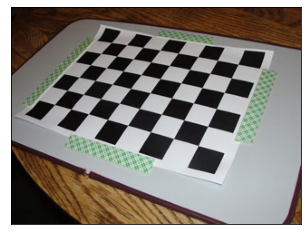

Corners of Image:


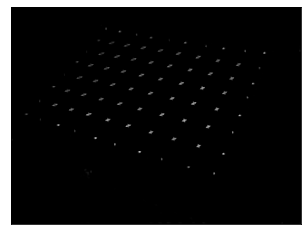

In [0]:
# Opens image
imgpath = '/content/input_hcd1.jpg'

file_url = "http://physbam.stanford.edu/cs448x/old/attachments/Optical_Motion_Capture_Guide/CheckerBoard.jpg"
r = requests.get(file_url, stream = True)
with open(imgpath, "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)  

img = mpimg.imread(imgpath)
# Converts to Grayscale (harris above only works on single channel)
img_gray = np.dot(img[...,:3], [0.299, 0.587, 0.114])

# Performs Corner Detection
r_vals = harris(img_gray, 1e11)[0]

print('Original Image:')
plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
plt.show()
print('Corners of Image:')
plt.imshow(r_vals, cmap=cm.gray, vmin=7000)
plt.xticks([])
plt.yticks([])
plt.show()

## What is Machine Learning?

Machine learning is a subset of AI that deals with programs that perform tasks that use rules not explicitly given to them. Other types of AI, such as the above corner/edge detector and AI for simple games, are not machine learning because their processes are explicitly given to the program to execute. One type of program that would be considered machine learning would be Fisher's linear discriminant to perform multi-class analysis:

(Though the actual content of the code does not matter for our purposes, notice the use of training and testing (validation) sets, which is a feature of many machine learning algorithms.)

In [0]:
# Computes the mean of a list of vectors
def vector_mean(vectors, size):
    mean = np.zeros(shape=(size, 1))
    length = 0
    for x in vectors:
        mean += x
        length += 1
    return mean / length

# Computes the between class scatter matrix between each class
def between_class_scatter(means, overall_mean, size, class_count):
    bcsm = np.zeros(shape=(size, size))
    for c in range(class_count):
        mean_min_mean = np.subtract(means[c], overall_mean)
        # Adds the multiplication of the difference of means for each class to the total
        bcsm += np.dot(mean_min_mean, np.transpose(mean_min_mean))
    return bcsm

# Computes the covariance matrix for a given class using its data and mean
def covariance(data, mean):
    size = len(data[0])
    cvm = np.zeros(shape=(size, size))
    length = 0
    for x in data:
        x_min_mean = x - mean
        cvm += x_min_mean * np.transpose(x_min_mean)
        length += 1
    return cvm / length

# Returns the Mahalanobis distance
def mahalanobis(vector, mean, covariance_matrix):
    sub = np.subtract(vector, mean)
    return np.dot(np.dot(sub.transpose(), np.linalg.inv(covariance_matrix)), sub)

# Gets features from a set of data
def train(training_data, training_labels, training_size, class_count, feature_size):
    print('Extracting Features From Training Set')

    # Creates a list that holds lists of features for their respective classes
    features = []
    for i in range(class_count):
        features.append([])

    count = 0
    percent = 0
    # Converts the data for each image into a usable format
    for x in range(training_size):
        img = training_data[x]
        # Calculates R scores using existing harris corner detection algorithm (threshold doesn't matter)
        r_scores = harris(img, 1)[0]
        # Sorts the numpy array by each element's value
        r_scores_sorted = np.sort(r_scores.flatten())
        # Gets a 20x1 feature vector for the image
        img_feature = np.array([np.append(r_scores_sorted[:int(feature_size/2)],
                                          r_scores_sorted[-int(feature_size/2):])]).transpose()
        # Appends the feature vector to a list for its class
        features[training_labels[x]].append(img_feature)

        # Tracks Progress for extracting Features
        count += 1
        if count == int(training_size / feature_size):
            percent += 5
            print('Progress: ', percent, '%')
            count = 0

    # Finds the class means and the overall mean
    means = []
    for class_features in features:
        means.append(vector_mean(class_features, feature_size))
    overall_mean = vector_mean(means, feature_size)

    # Computes the BCSM for all classes
    bcsm = between_class_scatter(means, overall_mean, feature_size, class_count)

    # Calculates the covariance matrices for each class and their sum 'A'
    covariances = []
    matrix_a = np.zeros(shape=(feature_size, feature_size))
    for c in range(class_count):
        # Computes the covariance matrix for class c
        covariances.append(covariance(features[c], means[c]))
        # Adds the covariance matrix to the sum
        matrix_a += covariances[c]

    # Computes inv(A)*bcsm and gets the eigenvalues
    a_inv_b = np.dot(np.linalg.inv(matrix_a), bcsm)
    # Gets the eigenvalues and vectors of A
    eigval, eigvec = np.linalg.eig(a_inv_b)
    eigval = eigval.real
    eigvec = eigvec.real
    # Gets the largest eigenvalues
    max_eigvals = np.sort(eigval)[-2:]
    # Gets their associated eigenvectors
    e1_index = list(eigval).index(max_eigvals[1])
    e2_index = list(eigval).index(max_eigvals[0])
    # Stacks the two row eigenvectors together
    h_transpose = np.row_stack((np.array([eigvec[:, e1_index]]), np.array([eigvec[:, e2_index]])))

    # Converts the class means and covariances to the fischer LDF space
    fischer_means = []
    fischer_covariances = []
    for c in range(class_count):
        fischer_means.append(np.dot(h_transpose, means[c]))
        fischer_covariances.append(np.dot(np.dot(h_transpose, covariances[c]), h_transpose.transpose()))

    # Returns the Fischer LDF means and covariances
    return [h_transpose.transpose(), fischer_means, fischer_covariances]


def test(testing_data, testing_labels, testing_size, class_count, feature_size, h, fischer_means, fischer_covariances):
    print('Determining Classes For Test Set')

    confusion_matrix = np.zeros(shape=(class_count, class_count))
    count = 0
    percent = 0
    for x in range(testing_size):
        img = testing_data[x]
        # Calculates R scores using existing harris corner detection algorithm (threshold doesn't matter)
        r_scores = harris(img, 1)[0]
        # Sorts the numpy array by each element's value
        r_scores_sorted = np.sort(r_scores.flatten())
        # Gets a 20x1 feature vector for the image
        img_feature = np.array([np.append(r_scores_sorted[:int(feature_size / 2)],
                                          r_scores_sorted[-int(feature_size / 2):])]).transpose()
        # Converts the feature to the Fischer LDF space
        fischer_feature = np.dot(h.transpose(), img_feature)

        # Determines the class the image belongs to by finding smallest mahal. distance between each class
        m_distances = []
        for c in range(class_count):
            m_distances.append(mahalanobis(fischer_feature, fischer_means[c], fischer_covariances[c]))
        chosen_class = m_distances.index(min(m_distances))
        actual_class = testing_labels[x]

        # Adds to the appropriate element of the confusion matrix
        confusion_matrix[actual_class][chosen_class] += 1

        # Tracks Progress for testing data
        count += 1
        if count == int(testing_size / feature_size):
            percent += 5
            print('Progress: ', percent, '%')
            count = 0

    return confusion_matrix


We can train and test the Fischer LDF on a set of data, particularly [CIFAR-10](https://keras.io/datasets/).

CIFAR-10 is divided into training and testing sets, which includes *labeled* data. This type of learning is known as *supervised learning*. *Unsupervised learning*, on the other hand, attempts to find meaningful connections in data without the use of labels to classify the data. [Cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis#Connectivity-based_clustering_(hierarchical_clustering) "Cluster Analysis - Wikipedia"), not shown here, is an example of a class of algorithms that utilize unsupervised learning techniques.

In [0]:
# Loads in CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255
# Converts to Grayscale (fldf above only works on single channel)
x_train = np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test = np.dot(x_test[...,:3], [0.299, 0.587, 0.114])
# Flattens the labels
y_train = y_train.flatten()
y_test = y_test.flatten()
# Defines the size of each set
# (Note: normally, these subsets would be chosen randomly, but this only uses
# the first n elements from each set for simplicity)
train_size = 1600
test_size = 400

# Trains the model
h, fischer_means, fischer_covariances = train(
    x_train[:train_size], y_train[:train_size], train_size, 10, 20)

Extracting Features From Training Set
Progress:  5 %
Progress:  10 %
Progress:  15 %
Progress:  20 %
Progress:  25 %
Progress:  30 %
Progress:  35 %
Progress:  40 %
Progress:  45 %
Progress:  50 %
Progress:  55 %
Progress:  60 %
Progress:  65 %
Progress:  70 %
Progress:  75 %
Progress:  80 %
Progress:  85 %
Progress:  90 %
Progress:  95 %
Progress:  100 %


For supervised learning techniques, it is standard to be able to display the accuracy of the model that you are working with. Here, we use a *confusion matrix* to display all predictions and their true classes. Hence, looking at the diagonal of this matrix is used to determine how often the model gives accurate predictions.

Determining Classes For Test Set
Progress:  5 %
Progress:  10 %
Progress:  15 %
Progress:  20 %
Progress:  25 %
Progress:  30 %
Progress:  35 %
Progress:  40 %
Progress:  45 %
Progress:  50 %
Progress:  55 %
Progress:  60 %
Progress:  65 %
Progress:  70 %
Progress:  75 %
Progress:  80 %
Progress:  85 %
Progress:  90 %
Progress:  95 %
Progress:  100 %


Confusion Matrix:


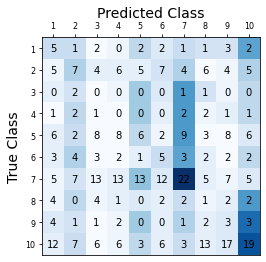

Class  1  has accuracy:  11.11 %
Class  2  has accuracy:  21.21 %
Class  3  has accuracy:  0.0 %
Class  4  has accuracy:  0.0 %
Class  5  has accuracy:  20.0 %
Class  6  has accuracy:  13.89 %
Class  7  has accuracy:  45.83 %
Class  8  has accuracy:  2.78 %
Class  9  has accuracy:  6.38 %
Class  10  has accuracy:  42.22 %


In [0]:
# Prints the accuracy for each class from the confusion matrix
def print_accuracy(matrix):
    i, j = matrix.shape
    if i != j:
        print('Confusion Matrix must be nxn')
        return
    for row in range(i):
        total = np.sum(matrix[row])
        percent = (matrix[row][row] / total) * 100
        print('Class ', row+1, ' has accuracy: ', round(percent, 2), '%')
    return

# Tests the model
confusion_matrix = test(x_test[:test_size], y_test[:test_size],
                        test_size, 10, 20, h, fischer_means, fischer_covariances)

# Prints the confusion matrix
print("\n\nConfusion Matrix:")
fig, ax = plt.subplots()
ax.imshow(confusion_matrix, cmap='Blues')
s = confusion_matrix.shape[0]
for i in range(s):
    for j in range(s):
        c = int(confusion_matrix[i,j])
        ax.text(i, j, str(c), va='center', ha='center')
ax.set_xlabel('Predicted Class')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('True Class')
ax.set_xticks(np.arange(s))
ax.set_xticklabels(np.arange(1,s+1))
ax.xaxis.tick_top()
ax.set_yticks(np.arange(s))
ax.set_yticklabels(np.arange(1,s+1))
plt.show()

# Prints the accuracy for each class
print_accuracy(confusion_matrix)

## What is Deep Learning?


Deep Learning is a type of machine learning that focuses on the use of neural networks to train and learn different types of data on. These neural networks are made with the structure of human brain functionality in mind; they have "nuerons" that make connections to one another. A more in depth look at the structure and examples of these neural networks can be seen later on.